In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('clustering_spark').getOrCreate()


## Read Hotels Data

In [2]:
hotels_data = spark.read.csv("hotels_data.csv", header = True, inferSchema = True)

## Converts String to Dates 

In [3]:
from pyspark.sql.functions import udf, col
from datetime import datetime
from pyspark.sql.types import DateType, IntegerType

# Converts string to date
def str_to_date(str):    
    return datetime.strptime(str, '%m/%d/%Y %H:%M')

# convert a regular function to pyspark function
udf_strToDate = udf(str_to_date, DateType())

# convert "checking_date" and "snapshot_date" to date types
hotels_data_with_dates = hotels_data.withColumn("checkin_date", udf_strToDate(col("Checkin Date")))
hotels_data_with_dates = hotels_data_with_dates.withColumn("snapshot_date", udf_strToDate(col("Snapshot Date")))

## Get 150 common hotels

In [4]:
from pyspark.sql.functions import desc

# group by hotel name and count, take the first 150 hotels with the biggest count 
count_by_hotel_names = hotels_data_with_dates.groupBy('Hotel Name').count().sort(desc('count')).limit(150)

# get a list of the first 150 hotel names 
first_150_hotel_names = count_by_hotel_names.toPandas()['Hotel Name'].tolist()

# filter hotels_data to include records from the 150 hotel names
hotels_150_data = hotels_data_with_dates.filter(col('Hotel Name').isin(first_150_hotel_names))

## Filter records by most common 40 checkin dates 

In [5]:
# group by checkin and count, take the first 40 with biggest count
count_by_checkin = hotels_150_data.groupBy('checkin_date').count().sort(desc('count')).limit(40)

# get a list of the most common 40 checkin dates
first_40_checkin = count_by_checkin.toPandas()['checkin_date'].tolist()

# filter hotels data by the 40 most common dates
hotels_by_40_checkin = hotels_150_data.filter(col('checkin_date').isin(first_40_checkin))

## Section 8

In [6]:
#creating unique list for Hotel Name - Checkin Date - Discount code dummy combination generating 
unique_hotels_names = hotels_by_40_checkin.select('Hotel Name').distinct().collect()
unique_hotels_names_list = [(row['Hotel Name']) for row in unique_hotels_names]

unique_checkins =  hotels_by_40_checkin.select("checkin_date").distinct().collect()
unique_checkins_list = [(row['checkin_date']) for row in unique_checkins]

unique_discount_code =  [1,2,3,4]

# Create records with max price for each discount code for each date
synth_data = []
import sys
for x in unique_hotels_names_list:
    for y in unique_checkins_list:
        for z in unique_discount_code:
            synth_data.append([x, y ,z, sys.maxsize])

#Making the schema of synth_data
from pyspark.sql.types import *
cSchema = StructType([StructField("Hotel Name", StringType()),StructField("checkin_date", DateType()),StructField("Discount Code",  IntegerType()),StructField("min(Discount Price)", LongType())])

#Creating dummy df
dummy_df = spark.createDataFrame(synth_data, schema=cSchema)

sliced_df = hotels_by_40_checkin.select('Hotel Name', 'checkin_date','Discount Code', 'Discount Price')

# joining dummy data with grouped data 
hotel_chekin_discountCode = sliced_df.union(dummy_df)

# group by Checkin - Hotel - Discount Code
hotel_chekin_discountCode = hotel_chekin_discountCode.groupBy('Hotel name','checkin_date', 'Discount Code').min('Discount Price')

#replacing sys.max with -1 
hotel_chekin_discountCode = hotel_chekin_discountCode.replace(sys.maxsize, -1)

#sorting date
hotel_chekin_discountCode = hotel_chekin_discountCode.orderBy(['Hotel name','checkin_date','Discount Code'])




In [7]:
# hotel_chekin_discountCode_ToMinus1 = hotel_chekin_discountCode.replace(sys.maxsize, -1)
# Partition data by hotel name
# hotelsPartitioned =  hotel_chekin_discountCode.repartition("Hotel name")

## Normalizing data


In [8]:
#split to two groups: one with price of -1, one with greater than -1
groupMinus = hotel_chekin_discountCode.filter(col('min(Discount Price)') == -1)
groupGreater = hotel_chekin_discountCode.filter(col('min(Discount Price)') > -1)

In [9]:
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
import pyspark.sql.functions as func

groupGreater.createOrReplaceTempView("normalization")

#Creating SQLContext for SQL converting
sqlContext = SQLContext(spark)
    
#Preparing data for normalization
dataFrame = sqlContext.table("normalization")
#Partioning data for groups so we can applay function on groups
windowSpec = Window.partitionBy(groupGreater['Hotel name'])  


#Normalize function
diff = func.max(dataFrame['min(Discount Price)']).over(windowSpec) - func.min(dataFrame['min(Discount Price)']).over(windowSpec)
normalize = func.when( diff == 0, 0).otherwise( ( dataFrame['min(Discount Price)'] - func.min(dataFrame['min(Discount Price)']).over(windowSpec) ) / diff * 100 )

# diff = func.max(dataFrame['min(Discount Price)']).over(windowSpec) - func.min(dataFrame['min(Discount Price)']).over(windowSpec) == 0, 0).otherwise( ( func.max(dataFrame['min(Discount Price)']).over(windowSpec) - func.min(dataFrame['min(Discount Price)']).over(windowSpec) ) * 100 )
# normalize =  ((dataFrame['min(Discount Price)'] - func.min(dataFrame['min(Discount Price)']).over(windowSpec)) / diff)

normalized_df = dataFrame.select(
  dataFrame['Hotel Name'],
  dataFrame['checkin_date'],
  dataFrame['Discount Code'],
  normalize.alias("Normal"))

normalized_df.toPandas().isnull().values.any()


False

### Joining back -1 values

In [26]:
#Changing column name for same schema
groupMinus = groupMinus.withColumnRenamed('min(Discount Price)','Normal')

#Union all data frames with sorting
normalized_df = normalized_df.union(groupMinus)
normalized_df = normalized_df.orderBy(['Hotel name','checkin_date','Discount Code'])


In [20]:
normalized_df.dtypes

[('Hotel Name', 'string'),
 ('checkin_date', 'date'),
 ('Discount Code', 'int'),
 ('Normal', 'double')]

## Flatten each hotel values to Vector Dense values

In [43]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.ml.linalg import Vectors, VectorUDT

to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

normal_toList = normalized_df.groupBy('Hotel name').agg(F.collect_list('Normal').alias("features"))
normal_features = normal_toList.withColumn("features",to_vector("features")).drop("Hotel Name")

#normal_toList.select("Normal").flatMap(lambda x : x)

#parsing to df 
#all_hotels_df =  normal_toList.select([normal_toList["Hotel name"]] +  [normal_toList.Normal[i] for i in range(160)])

## Calculating Bisecting K-Means 

In [48]:
from pyspark.ml.clustering import BisectingKMeans

bkm = BisectingKMeans(k=4, minDivisibleClusterSize=1.0)
model = bkm.fit(normal_features)
centers = model.clusterCenters()
print(centers)


# NOTES
# The Bisecting algorithem is an top-down algorithem.
# First, it collect the data to the driver, and on each divide it's split the data into partitions to make it parellelize 
# without dependeny of data.

Py4JJavaError: An error occurred while calling o1602.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 454.0 failed 1 times, most recent failure: Lost task 9.0 in stage 454.0 (TID 30816, localhost, executor driver): java.lang.IllegalArgumentException: requirement failed
	at scala.Predef$.require(Predef.scala:212)
	at org.apache.spark.mllib.linalg.BLAS$.axpy(BLAS.scala:45)
	at org.apache.spark.mllib.clustering.BisectingKMeans$ClusterSummaryAggregator.add(BisectingKMeans.scala:291)
	at org.apache.spark.mllib.clustering.BisectingKMeans$$anonfun$org$apache$spark$mllib$clustering$BisectingKMeans$$summarize$1.apply(BisectingKMeans.scala:271)
	at org.apache.spark.mllib.clustering.BisectingKMeans$$anonfun$org$apache$spark$mllib$clustering$BisectingKMeans$$summarize$1.apply(BisectingKMeans.scala:271)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$aggregateByKey$1$$anonfun$apply$6.apply(PairRDDFunctions.scala:172)
	at org.apache.spark.util.collection.ExternalSorter$$anonfun$5.apply(ExternalSorter.scala:189)
	at org.apache.spark.util.collection.ExternalSorter$$anonfun$5.apply(ExternalSorter.scala:188)
	at org.apache.spark.util.collection.AppendOnlyMap.changeValue(AppendOnlyMap.scala:144)
	at org.apache.spark.util.collection.SizeTrackingAppendOnlyMap.changeValue(SizeTrackingAppendOnlyMap.scala:32)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:194)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1661)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1649)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1648)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1648)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1882)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1820)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.mllib.clustering.BisectingKMeans$.org$apache$spark$mllib$clustering$BisectingKMeans$$summarize(BisectingKMeans.scala:274)
	at org.apache.spark.mllib.clustering.BisectingKMeans.run(BisectingKMeans.scala:154)
	at org.apache.spark.ml.clustering.BisectingKMeans.fit(BisectingKMeans.scala:266)
	at org.apache.spark.ml.clustering.BisectingKMeans.fit(BisectingKMeans.scala:212)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed
	at scala.Predef$.require(Predef.scala:212)
	at org.apache.spark.mllib.linalg.BLAS$.axpy(BLAS.scala:45)
	at org.apache.spark.mllib.clustering.BisectingKMeans$ClusterSummaryAggregator.add(BisectingKMeans.scala:291)
	at org.apache.spark.mllib.clustering.BisectingKMeans$$anonfun$org$apache$spark$mllib$clustering$BisectingKMeans$$summarize$1.apply(BisectingKMeans.scala:271)
	at org.apache.spark.mllib.clustering.BisectingKMeans$$anonfun$org$apache$spark$mllib$clustering$BisectingKMeans$$summarize$1.apply(BisectingKMeans.scala:271)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$aggregateByKey$1$$anonfun$apply$6.apply(PairRDDFunctions.scala:172)
	at org.apache.spark.util.collection.ExternalSorter$$anonfun$5.apply(ExternalSorter.scala:189)
	at org.apache.spark.util.collection.ExternalSorter$$anonfun$5.apply(ExternalSorter.scala:188)
	at org.apache.spark.util.collection.AppendOnlyMap.changeValue(AppendOnlyMap.scala:144)
	at org.apache.spark.util.collection.SizeTrackingAppendOnlyMap.changeValue(SizeTrackingAppendOnlyMap.scala:32)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:194)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [45]:
from pyspark.ml.linalg import Vectors
data = [(Vectors.dense([0.0, 0.0]),), (Vectors.dense([1.0, 1.0]),),(Vectors.dense([9.0, 8.0]),), (Vectors.dense([8.0, 9.0]),)]
df = spark.createDataFrame(data, ["features"])
bkm = BisectingKMeans(k=2, minDivisibleClusterSize=1.0)
model = bkm.fit(df)
centers = model.clusterCenters()
len(centers)


2

In [46]:
df.dtypes

[('features', 'vector')]

## Dendogram

      Hotel name  Normal[0]  Normal[1]  Normal[2]  Normal[3]  Normal[4]  \
0  Bentley Hotel       -1.0       -1.0       -1.0       -1.0       -1.0   

   Normal[5]  Normal[6]  Normal[7]  Normal[8]     ...       Normal[150]  \
0       -1.0       -1.0       -1.0       -1.0     ...              -1.0   

   Normal[151]  Normal[152]  Normal[153]  Normal[154]  Normal[155]  \
0         -1.0         -1.0         -1.0         -1.0         -1.0   

   Normal[156]  Normal[157]  Normal[158]  Normal[159]  
0         -1.0         -1.0    11.147851         -1.0  

[1 rows x 161 columns]


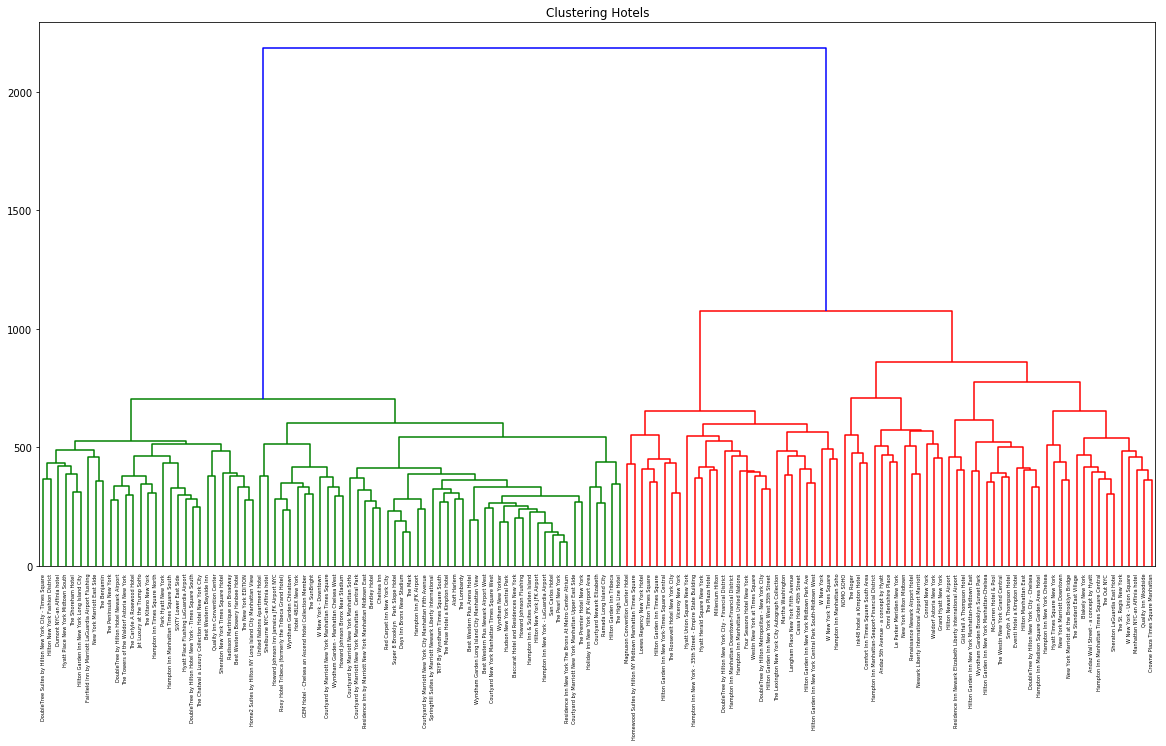

In [15]:
#importing clustering libaries 
from scipy.cluster.hierarchy import dendrogram, linkage 
from matplotlib import pyplot as plt
from scipy import cluster
shc = cluster.hierarchy

# back to pandas
vector = all_hotels_df.toPandas()

print (vector[vector["Hotel name"] == "Bentley Hotel"])

#preproccesing data for clustering
labels = vector.values[:,0]
data = vector.values[:,1:160]
plt.figure(figsize=(20, 10))  
plt.title("Clustering Hotels")  

# "ward" - minimizes the variance between clusters, that means that each two clusters were combine if their variance is alike 
Z = shc.linkage(data, method='ward')
dend = shc.dendrogram(Z, labels=labels) 

## Hotel to Cluster

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

#running the algorithem again in a diffrent way
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
clusters = cluster.fit_predict(vector.values[:,1:160])  

hotels = pd.DataFrame.from_records(vector.values)

hotels["cluster"] = clusters
hotels = hotels[[0,"cluster"]]
hotels.sort_values(by=["cluster"],ascending=True,inplace=True)

hotels["Count"] = hotels.groupby("cluster")[0].transform("count")
# hotels[hotels[0] == "NOMO SOHO"]
hotels